In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
import pandas as pd
import numpy as np
import spell 

from nltk.sentiment import vader
from nltk.tokenize import TweetTokenizer
import nltk

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer

from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from Visualization import Visualization
from sklearn.utils import shuffle

from imblearn.metrics import classification_report_imbalanced
from sklearn import metrics
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler


from sklearn import svm
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import confusion_matrix
from matplotlib import cm as cmap

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

/Users/rcortez/anaconda/envs/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [3]:
data = pd.read_csv('rebtel_w_lexicon.csv')
data = data.dropna(subset=['Rel_title'], how='any')
data = data.reset_index()
del data['index']

In [ ]:
data.head(n=2)

## NORMALIZATION

In [5]:
v = vader.SentimentIntensityAnalyzer()
visual = Visualization()

In [6]:
def isrelevant(word):
    
    
    neu_relevant = {'big','app','skype','call','calls',
                    'scamming','billed',' messaging',
                    'website','cant','logo','max','go',
                    'get','cheap'}
    
    
    pol =  v.polarity_scores(word)
    
    if pol['neg'] == 1 or pol['pos'] == 1:
        return True
    else:
        if not word.isalpha():
            if word == "n't":
                return False
            else:
                return True
        else:
            if word.lower() in neu_relevant:
                return True
            else:
                
                return False
    

In [7]:
#tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)

def spell_checked(data,columnName):
    
    avoid = {"``",",",'"',"`","-"}
    
    crtd_messages = []

    for m in data[columnName]:
        
        n_w = []
        for word in nltk.word_tokenize(m):
            if not isrelevant(word):
                tmp_w = spell.correct(word)
            else:
                tmp_w = word
            if tmp_w not in avoid:
                n_w.append(tmp_w)
        n_m = " ".join(n_w) 
        crtd_messages.append(n_m)
    
    return crtd_messages   

In [8]:
data['R_chk_title'] = spell_checked(data,'Rel_title')

In [9]:
data['R_chk_review'] = spell_checked(data,'Rel_review')

In [20]:
data.columns

Index(['Review', 'Title', 'Rating', 'day', 'month', 'year', 'hour', 'minute',
       'second', 'dayofweek', 'weekofyear', 'Country', 'Username', 'Reviews',
       'Reads', 'Useful', 'Genre', 'C_review', 'C_title', 'Rel_review',
       'Rel_title', 'C_wp_review', 'C_wp_title', 'Rel_wp_review',
       'Rel_wp_title', 'r_compound', 'r_negative', 'r_positive', 'r_neutral',
       't_compound', 't_negative', 't_positive', 't_neutral', 'predictions'],
      dtype='object')

In [12]:
# Lemmatization
wordnet = WordNetLemmatizer() 

def lemmatization(data,columnName):
    lemmas = []
    for message in data[columnName]:
        tkn = nltk.word_tokenize(message)
        wordnet_lemmas = [wordnet.lemmatize(token) for token in tkn] 
        lemmas.append(" ".join(wordnet_lemmas))
    return lemmas

In [13]:
data["Lems_title"] = lemmatization(data,"R_chk_title")

In [14]:
data["Lems_review"] = lemmatization(data,"R_chk_review")

In [15]:
#Stemming
def stemming(data,columnName,stem): 
    lemmas = []
    
    snowball = SnowballStemmer("english")
    porter = PorterStemmer()
    lancaster = LancasterStemmer()
    
    for message in data[columnName]:
        tkn = nltk.word_tokenize(message)
        if stem is "snow":
            stemmed = [snowball.stem(token) for token in tkn]
        elif stem is "porter":
            stemmed = [porter.stem(token) for token in tkn]
        elif stem is "lanc":
            stemmed = [lancaster.stem(token) for token in tkn]
        lemmas.append(" ".join(stemmed))
    return lemmas

In [16]:
data["Snow_title"] = stemming(data,"R_chk_title","snow")  
data["Snow_review"] = stemming(data,"R_chk_review","snow")

In [17]:
data["Porter_title"] = stemming(data,"R_chk_title","porter") 
data["Porter_review"] = stemming(data,"R_chk_review","porter") 

In [18]:
data["Lanc_title"] = stemming(data,"R_chk_title","lanc") 
data["Lanc_review"] = stemming(data,"R_chk_review","lanc") 

In [ ]:
data.head(n=2)

In [19]:
# Join text from title and review
merged_text = []
for i in range(len(data)):
    mrgd = data["Lems_title"][i] + data["Lems_review"][i]
    merged_text.append(mrgd)

In [20]:
def mg_title_rev(data,approach):
    # Join text from title and review
    merged_text = []
    for i in range(len(data)):
        mrgd = data[approach + "_title"][i] + " " + data[approach + "_review"][i]
        merged_text.append(mrgd)
    return merged_text
    

In [21]:
data['Lems_title_review'] = mg_title_rev(data,"Lems")

In [22]:
data['Snow_title_review'] = mg_title_rev(data,"Snow")
data['Porter_title_review'] = mg_title_rev(data,"Porter")
data['Lanc_title_review'] = mg_title_rev(data,"Lanc")
data['R_chk_title_review'] = mg_title_rev(data,'R_chk')

In [23]:
#data['title_review'] = merged_text
data = data.reindex()

In [4]:
# Build a balanced train/test set
r1_df = data.loc[data.Rating == 1]
r2_df = data.loc[data.Rating == 2]
r3_df = data.loc[data.Rating == 3]
r4_df = data.loc[data.Rating == 4]
r5_df = data.loc[data.Rating == 5]
dfs = [r1_df, r2_df, r3_df, r4_df, r5_df]

In [5]:
t_size = 0.7

train_set = []
test_set = []

for df in dfs:
    
    train_size = int(len(df)* t_size)
    
    train_data = df[0:train_size].reset_index(drop=True)
    test_data = df[train_size:].reset_index(drop=True)
    
    train_set.append(train_data)
    test_set.append(test_data)

In [6]:
df_train = pd.concat(train_set[:],axis=0)
df_train = df_train.reset_index(drop=True)

df_test = pd.concat(test_set[:],axis=0)
df_test = df_test.reset_index(drop=True)


In [7]:
df = pd.concat([df_train,df_test],axis=0)
df = shuffle(df).reset_index(drop=True)

In [8]:
# Extract true labels from data
y_data = df["Rating"].values
y_data = y_data.reshape(y_data.shape[0],)

In [ ]:
"""
# 
print("Classes: ")
print(np.unique(y_train))

# Summarize number of words
print("Number of words: ")
print(len(np.unique(np.hstack(x_train))))

# Summarize review length
print("Review length: ")
result = [len(x) for x in x_train]
print("Mean %.2f words (%f)" % (np.mean(result), np.std(result)))
# plot review length
plt.boxplot(result)
plt.title('Lenght of words in message reviews')
plt.show()

# Summarize review length
print("Review length: ")
result = [len(x) for x in x_train]
print("Mean %.2f words (%f)" % (np.mean(result), np.std(result)))
# plot review length
plt.boxplot(result)
plt.title('Lenght of words in title reviews')
plt.show()
"""

In [ ]:
#Check distribution of classes
#df.Rating.value_counts().plot(kind='bar')

In [9]:
ctyNames = df.Country.unique() 
ctyNames = np.append(ctyNames,['Unkown'])
countries = {ctyNames[i]: i for i in range(0, len(ctyNames))}

In [14]:
def map_country(ctyName,countries):
    
    if ctyName in countries:
        value = countries[ctyName]
    else:
        value = countries['Unkown']

    return value

In [15]:
df['Key_country'] = [map_country(cty,countries) for cty in df.Country]

In [11]:
# Set up Vectorizer with the X most frequent words
top_words = 125 #145 
#vectorizer = #CountVectorizer(ngram_range=(1,2))
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None,   \
                             max_features = top_words)
RANDOM_STATE = 42

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

n_features = top_words
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')

In [19]:
df.columns

Index(['Review', 'Title', 'Rating', 'day', 'month', 'year', 'hour', 'minute',
       'second', 'dayofweek', 'weekofyear', 'Country', 'Username', 'Reviews',
       'Reads', 'Useful', 'Genre', 'C_review', 'C_title', 'Rel_review',
       'Rel_title', 'C_wp_review', 'C_wp_title', 'Rel_wp_review',
       'Rel_wp_title', 'r_compound', 'r_negative', 'r_positive', 'r_neutral',
       't_compound', 't_negative', 't_positive', 't_neutral', 'predictions',
       'Key_country'],
      dtype='object')

In [16]:
#ADD MORE FEATURES
add_feats = df[['Reads','r_compound','r_negative', 'r_positive',
                'r_neutral','t_compound','t_negative', 't_positive',
                't_neutral','dayofweek','weekofyear','Key_country',
                "Useful"]]
a_feats = add_feats.values

In [18]:
#Select method to train model (Lems/Snow/Porter/Lanc)
method =  "Lanc"
add_feats = True
seed = 13 

x_fts = vectorizer.fit_transform(df[method + '_title_review'])
x_fts = x_fts.toarray()

if add_feats:
    x_fts = np.concatenate((x_fts,a_feats),axis=1)


np.random.seed(seed)

train_size = 0.75
train_size = int(len(x_fts)* train_size)

x_train, y_train = x_fts[0:train_size], df['Rating'][0:train_size]
X_test, Y_test = x_fts[train_size:], df['Rating'][train_size:] 

KeyError: 'Lanc_title_review'

In [70]:
from time import time
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(df[method + '_title_review'])
print("done in %0.3fs." % (time() - t0))

x_fts = tfidf.toarray()

if add_feats:
    x_fts = np.concatenate((x_fts,a_feats),axis=1)


np.random.seed(seed)

train_size = 0.75
train_size = int(len(x_fts)* train_size)

x_train, y_train = x_fts[0:train_size], df['Rating'][0:train_size]
X_test, Y_test = x_fts[train_size:], df['Rating'][train_size:] 

done in 0.064s.


In [175]:
ros = RandomOverSampler(random_state=RANDOM_STATE)
x_train, y_train = ros.fit_sample(x_train, y_train)
x_test, y_test = ros.fit_sample(X_test, Y_test)

x_data  = np.concatenate((x_train,x_test),axis=0)
y_data = np.concatenate((y_train,y_test),axis=0)


In [71]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_data)

encoder.fit(y_train)

encoded_Y = encoder.transform(y_train)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = np_utils.to_categorical(encoded_Y)

encoded_Y_test = encoder.transform(Y_test)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = np_utils.to_categorical(encoded_Y_test)

encoded_Y = encoder.transform(y_data)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

In [72]:
# split into 67% for train and 33% for test
x_train, x_test, y_train, y_test = train_test_split(x_train, dummy_y_train, test_size=0.33, random_state=seed)

In [73]:
x_train.shape

(909, 138)

In [74]:
model = Sequential()
model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(32, init='normal', activation='relu'))
#model.add(Dense(64, init='normal', activation='relu'))
model.add(Dense(5, init='normal', activation='sigmoid'))
# compile model for a multi-class classification problem (optimizer = adam/rmsprop/sgd)
#sgd = SGD(lr=0.03, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train,y_train,validation_data=(x_test,y_test),shuffle=True, nb_epoch=80, batch_size=128)


Train on 909 samples, validate on 448 samples
Epoch 1/80
909/909 [==============================] - 0s - loss: 1.6207 - acc: 0.1364 - val_loss: 1.5778 - val_acc: 0.4643
Epoch 2/80
909/909 [==============================] - 0s - loss: 1.5726 - acc: 0.4774 - val_loss: 1.5536 - val_acc: 0.4754
Epoch 3/80
909/909 [==============================] - 0s - loss: 1.5367 - acc: 0.4851 - val_loss: 1.5262 - val_acc: 0.4799
Epoch 4/80
909/909 [==============================] - 0s - loss: 1.5036 - acc: 0.4818 - val_loss: 1.4873 - val_acc: 0.4688
Epoch 5/80
909/909 [==============================] - 0s - loss: 1.4656 - acc: 0.4730 - val_loss: 1.4460 - val_acc: 0.4688
Epoch 6/80
909/909 [==============================] - 0s - loss: 1.4282 - acc: 0.4730 - val_loss: 1.4141

In [75]:
# Final evaluation of the model
scores = model.evaluate(X_test, dummy_y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 56.95%


In [76]:
test_preds = model.predict_classes(X_test)

 32/453 [=>............................] - ETA: 0s

In [77]:
c_y = dummy_y_test.argmax(1)

In [78]:
print(classification_report_imbalanced(y_pred=test_preds,y_true=c_y))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.60      0.94      0.90      0.73      0.77      0.57        63
          1       0.00      0.00      1.00      0.00      0.00      0.00        23
          2       0.38      0.40      0.91      0.39      0.59      0.33        53
          3       0.37      0.11      0.93      0.17      0.53      0.27       118
          4       0.63      0.84      0.62      0.72      0.72      0.51       196

avg / total       0.49      0.57      0.79      0.50      0.63      0.41       453



/Users/rcortez/anaconda/envs/python3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rcortez/anaconda/envs/python3/lib/python3.5/site-packages/imblearn/metrics/classification.py:240: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples.
  average, warn_for)


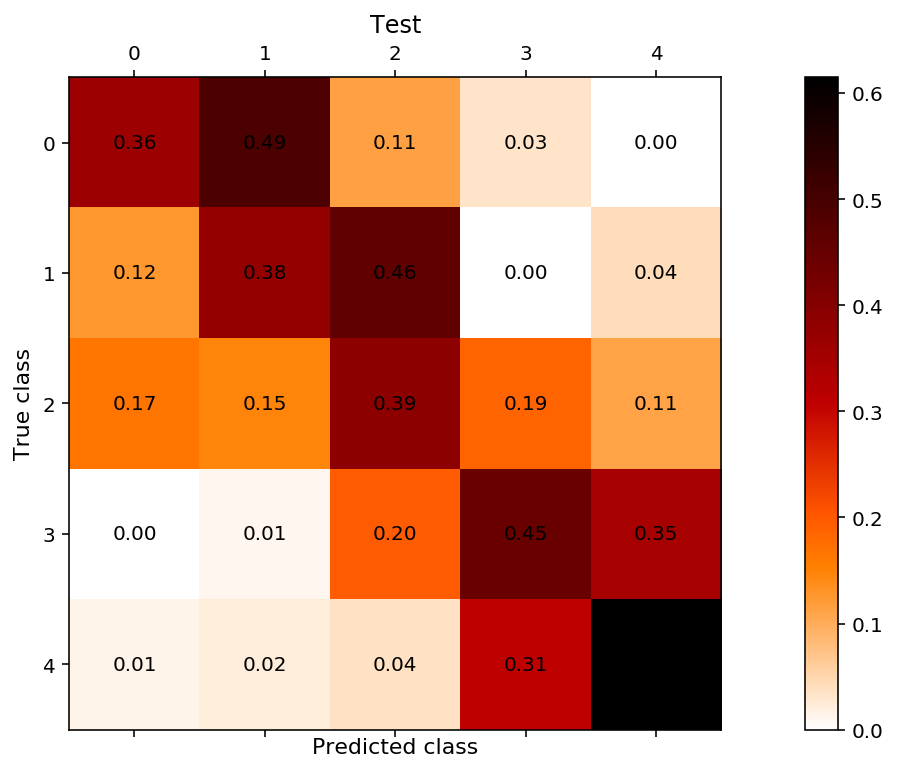

In [184]:
visual.plot_confusion_matrix(c_y,test_preds,title='Test')

In [41]:
from keras.optimizers import SGD
from keras.layers import Dropout
model = Sequential()

In [ ]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(32, input_dim=top_words, init='normal', activation='relu'))
    model.add(Dense(5, init='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

estimator = KerasClassifier(build_fn=baseline_model, nb_epoch=3, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

results = cross_val_score(estimator,x_data,dummy_y, cv=kfold,scoring='average_precision')
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [ ]:
#cross_validation = StratifiedShuffleSplit(y_data, n_iter=10, test_size=0.3, random_state=RANDOM_STATE)
cross_validation =   StratifiedKFold (y_data,n_folds=5, random_state=RANDOM_STATE)

scores = []
confusion_matrices = []
clf_models = []
avgs = []

for train_index,test_index in cross_validation:

    clf = None

    dx_train, dy_train = x_data[train_index], y_data[train_index]
    dx_test, dy_test = x_data[test_index], y_data[test_index]
    
    clf = RandomForestClassifier(n_estimators= 37, n_jobs=-1)
    #clf = svm.SVC(decision_function_shape='ovo',random_state=RANDOM_STATE,probability=True)
    clf.fit(dx_train, dy_train)
    clf_models.append(clf)
    
    # Saving the scores.
    test_score = clf.score(dx_test, dy_test)
    test_preds = clf.predict(dx_test)
    rep = classification_report_imbalanced(dy_test, test_preds)
    txt_rep = nltk.word_tokenize(rep[500:1000])
    avg_total = [float(txt_rep[i]) for i in range(3,len(txt_rep))]
    avgs.append(avg_total)
    scores.append(test_score)


    # Saving the confusion matrices.
    data_classes_pred = clf.predict(dx_test) 
    cm = confusion_matrix(dy_test, test_preds)
    confusion_matrices.append(cm)
    
print('Average precision :', str(np.mean([avgs[i][0] for i in range(len(avgs))])))
print('Average recall :', str(np.mean([avgs[i][1] for i in range(len(avgs))])))
print('Average F-score :', str(np.mean([avgs[i][3] for i in range(len(avgs))])))

In [ ]:
from sklearn.externals import joblib
joblib.dump(clf, 'best_RFC_text_SSS.pkl', compress=9)
#model_clone = joblib.load('best_SVM_text.pkl')